<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Очищение-текста" data-toc-modified-id="Очищение-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очищение текста</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#VADER" data-toc-modified-id="VADER-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>VADER</a></span></li><li><span><a href="#RoBERTa" data-toc-modified-id="RoBERTa-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>RoBERTa</a></span></li></ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
 # для RoBERTa
!pip install transformers

In [2]:
# Для работы токенайзера RoBERTa
!pip install sentencepiece 

In [3]:
!pip install tensorflow

In [4]:
# для RoBERTa
!pip3 install torch

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import warnings
import re
import nltk
import tensorflow
import torch

from sklearn.utils import resample
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import pipeline as trans_pipeline

from scipy.special import softmax

In [6]:
warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv('toxic_comments (1).csv')

In [8]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Видим, что в датафрейме всего две колонки: текст (признак) и токсичность (таргет)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 159571 entries, 0 to 159570

Data columns (total 2 columns):

 #   Column  Non-Null Count   Dtype 

---  ------  --------------   ----- 

 0   text    159571 non-null  object

 1   toxic   159571 non-null  int64 

dtypes: int64(1), object(1)

memory usage: 2.4+ MB


Text(0.5, 1.0, 'Count of Toxic and Non-toxic Comments')

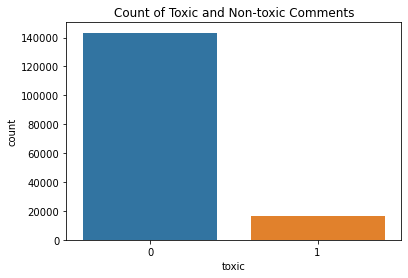

In [10]:
sns.countplot(data['toxic'])
plt.title('Count of Toxic and Non-toxic Comments')

Можно увидеть, что классы несбалансированы, поэтому при обучении могут возникнуть трудности. Проведем downsampling, т.к. 156 000 строк слишком много займет по времени.

### Downsampling

In [11]:
not_toxic = resample(data[data['toxic']==0],
                    replace=True,
                    n_samples=len(data[data['toxic']==1]),
                    random_state=12345)

In [12]:
print(not_toxic.shape)

(16225, 2)


In [13]:
data_downsampled = pd.concat([data[data['toxic']==1], not_toxic])

In [14]:
data_downsampled['toxic'].value_counts()

1    16225
0    16225
Name: toxic, dtype: int64

In [15]:
data_downsampled = data_downsampled[14225:18225]

Text(0.5, 1.0, 'Count of Toxic and Non-toxic Comments of Balanced Data')

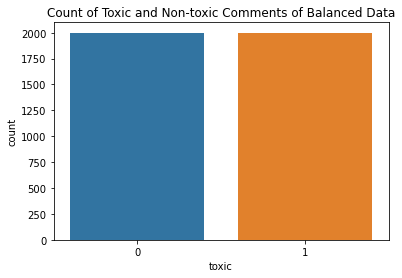

In [16]:
sns.countplot(data_downsampled['toxic'])
plt.title('Count of Toxic and Non-toxic Comments of Balanced Data')

In [17]:
data_downsampled = data_downsampled.reset_index().drop('index', axis=1)

Найс! Теперь можно работать.

### Очищение текста

Сначала **токенизация**, потом **лемматизация**, а потом очистка текста от **стоп-слов**. После **маркеры** начала и конца предложения.

In [18]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
stopwords = [word for word in stopwords if word not in ("doesn't", "no", "off", "haven't", "aren't",
                                                        "hasn't", "won't", "don't", "weren't", "isn't", "most",
                                                       "needn't", "hadn't", "wouldn't", "wasn't", "couldn't",)]

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\ryuze_\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\ryuze_\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!


In [19]:
lemmatizer = WordNetLemmatizer()

In [20]:
from tqdm import tqdm

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\ryuze_\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
def clean_sentences(data):
    tweets = []

    for sent in tqdm(data):
        
        # Удаление символом не из алфавита
        tweet_text = re.sub("[^a-zA-Z]"," ", sent)
    
        # Токенизация текста
        words = word_tokenize(tweet_text.lower())
        
        # Стемминг слов для отбросов окончаний
        ps = nltk.stem.porter.PorterStemmer()
        words = [ps.stem(word) for word in words]
    
        # Лемматизация каждого слова
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        clear_words = [lemma_words for lemma_words in lemma_words if lemma_words not in stopwords]
        
        tweets.append(lemma_words)
        
        tweets_str = [ ' '.join(item) for item in tweets]

    return tweets_str

In [23]:
data_downsampled['process_text'] = clean_sentences(data_downsampled['text'])

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:18<00:00, 220.69it/s]


In [24]:
data_downsampled

,text,toxic,process_text
0,you should just die in a hole while the ideiot...,1,you should just die in a hole while the ideiot...
1,unblock|unblock my restriction from editing yo...,1,unblock unblock my restrict from edit you jack...
2,"cmon, im waiting for ur cum over over all over...",1,cmon im wait for ur cum over over all over thi...
3,I'm gonna fuck you up sand niger!,1,i m gon na fuck you up sand niger
4,being cooler than your faggot ass,1,be cooler than your faggot as
...,...,...,...
3995,DYK nomination of Iron railing\n Hello! Your s...,0,dyk nomin of iron rail hello your submiss of i...
3996,Bellend \n\nUr a bellend,0,bellend ur a bellend
3997,"""\n\n Adding content to multiple articles \n\n...",0,ad content to multipl articl hi kelseymar take...
3998,William Fothergill Robinson \n\n William Fothe...,0,william fothergil robinson william fothergil r...


### Обучение

Для предсказаний возьмем три способоа:
* TF-IDF вместе с scikit-learn pipeline и наивным Байесовским методом
* VADER - подходит для работы с текстами соцсетей
* BERT (RoBERTa)

#### TF-IDF

In [25]:
# Разделение на признаки и тарге

data_train, data_test = model_selection.train_test_split(data_downsampled, test_size=.5, shuffle=True)

y_train = data_train['toxic'].values
y_test = data_test['toxic'].values

In [26]:
# Создание TF-IDF с Bag-of-Words
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=2000, ngram_range=(1,2))

In [27]:
corpus = data_train['process_text']

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

In [28]:
classifier = naive_bayes.MultinomialNB()

In [29]:
# pipeline для быстрой обработки
model = pipeline.Pipeline([('vectorizer', vectorizer),
                          ('classifier', classifier)])

# обучение классификатора
model['classifier'].fit(X_train, y_train)

# Тестирование
X_test = data_test['process_text']
predictions = model.predict(X_test)

print('F1-мера TF-IDF', f1_score(y_test, predictions))

F1-мера TF-IDF 0.8711779448621554


(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

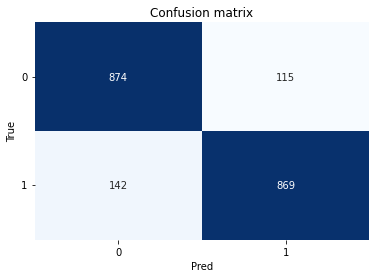

In [30]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
plt.yticks(rotation=0)

#### VADER

Для VADER не нужно заранее очищать текст от знаков препинаний, капсов, т.к. модель учитывает это все при работе. Также эта модель не требует обучающей выборки.

In [31]:
# Скачивание VADER
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to

[nltk_data]     C:\Users\ryuze_\AppData\Roaming\nltk_data...

[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [32]:
sia = SentimentIntensityAnalyzer()

In [33]:
from tqdm.notebook import tqdm

In [34]:
# Копирование датафрейма , т.к. старый будет использоваться
data_new = data.copy()

In [35]:
data_new['compound'] = data_new['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Замена на классы токсичности
data_new['vader_prediction'] = np.where(data_new['compound'] < 0, 1, 0)

print('F1-мера VADER:', f1_score(data_new['toxic'], data_new['vader_prediction']))

F1-мера VADER: 0.33402332652857286


(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

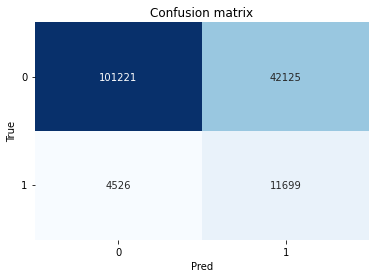

In [36]:
cm = confusion_matrix(data_new['toxic'], data_new['vader_prediction'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
plt.yticks(rotation=0)

Печальный результат, вероятнее всего, предобратботки текста не помешало бы. Попробуем пустить ресемплированный датасет и этот же датасет с предобработанным текстом через VADER.

In [37]:
data_downsampled['compound'] = data_downsampled['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

data_downsampled['vader_prediction'] = np.where(data_downsampled['compound'] < 0, 1, 0)

print('F1-мера VADER:', f1_score(data_downsampled['toxic'], data_downsampled['vader_prediction']))

F1-мера VADER: 0.7144985104270111


In [38]:
data_downsampled['compound'] = data_downsampled['process_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

data_downsampled['vader_prediction'] = np.where(data_downsampled['compound'] < 0, 1, 0)

print('F1-мера VADER:', f1_score(data_downsampled['toxic'], data_downsampled['vader_prediction']))

F1-мера VADER: 0.7259591429995017


(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

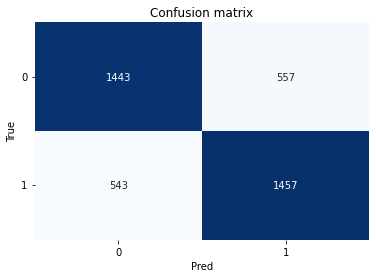

In [39]:
cm = confusion_matrix(data_downsampled['toxic'], data_downsampled['vader_prediction'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix")
plt.yticks(rotation=0)

Результат заметно стал лучше, но не дотягивает до порогового значения для задания. Перейдем к нейросети ✨RoBERTa✨

#### RoBERTa

In [40]:
# Скачивание натренированной модели с Hugging Face
MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [41]:
max_length = 512

In [42]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

In [43]:
def polarity_score(text):
    #text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True)
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    if scores[0] > scores[2]:
        return 1
    else:
        return 0

In [44]:
# Перемешивание строк
data_downsampled = data_downsampled.sample(frac=1).reset_index(drop=True)

In [45]:
from tqdm.notebook import tqdm

In [46]:
data_roberta = data_downsampled[:500]

In [47]:
for i in tqdm(data_roberta['process_text']):
    data_roberta['roberta_predictions'] = polarity_score(i)

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
print('F1-мера RoBERTa:', f1_score(data_roberta['toxic'], data_roberta['roberta_predictions']))

F1-мера RoBERTa: 0.6737400530503979


(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

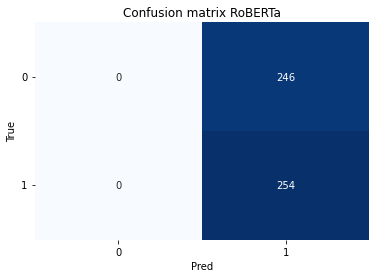

In [49]:
cm = confusion_matrix(data_roberta['toxic'], data_roberta['roberta_predictions'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", title="Confusion matrix RoBERTa")
plt.yticks(rotation=0)

По матрице неточностей можно увидеть, что у RoBERTa проблемы с определением нулевого класса (нетоксичность)

В процессе изучении темы про RoBERTa, было так много деталей, что я запуталась. Если у тебя будут замечания, как улучшить оценку у данной модели, я с радостью их применю!

## Выводы

В работе было использовано три спобоса:
* TF-IDF с мешком слов через классификатор наивного байесовского метода
* VADER
* RoBERTa

Оценки у этих подходов:
1. TF-IDF - 0.8553
2. VADER - 0.7259 на обработанном тексте
3. RoBERTa - 0.6394

В проекте на данный момент неверно использована модель: в этом проекте использована модель для определения сентиментальности (3 класса), а нужно токсичности (2 класса). Отличаются эти нейронные сети верхними слоями. Также проведено ресемплирование как на обучающем датасете, так и на тестовом. Это тоже неверно, ресемплирование надо проводить только на обучающей. Из-за нехватки времени проект оставлен в таком сыром виде.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны